# Hands On Data in Astronomy Pt. 2

In this second part we will lear how to load the data, look into the events, define On and Off regions to ectract the signal and finally estimate the flux in energy

## Table of contents
 - [0. Setup](#0.-Setup)
 - [1. Select Data Sample](#1.-Select-Data-Sample)
 - [2. Observation Info: Time, Azimuth and Altitude](#2.-Observation-Info:-Time,-Azimuth-and-Altitude)
 - [3. A first look into the events](#3.-A-first-look-into-the-events)
 - [4. Source and pointing position](#4.Source-and-pointing-position)
 - [5. On and Off regions](#5.-On-and-Off-regions)
 - [6. Event selection](#6.-Event-selection)
 - [7. Signal extraction](#7.-Signal-extraction)
 - [8. Flux in Energy](#8.-Flux-in-Energy)

## 0. Setup

In [1]:
%matplotlib inline  
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import astropy
import os
print('numpy:', np.__version__)
print('astropy:', astropy.__version__)

numpy: 1.24.4
astropy: 5.3.3


In [3]:
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from astropy.io import fits, ascii

import glob

To open the fits file we use `fits.open()` and just specify the filename as an argument:

## 1. Select Data Sample

In [339]:
# Get the value of the environment variable

gammapy_data_path = os.environ.get('GAMMAPY_DATA')
if not gammapy_data_path:
    raise ValueError("The GAMMAPY_DATA environment variable is not set!")


In [340]:
!ls $gammapy_data_path

README.md           cta-caldb           fermi-3fhl-gc       hess-dl3-dr1
catalogs            dark_matter_spectra fermi_3fhl          joint-crab
cta-1dc             ebl                 figures             magic
cta-1dc-gc          fermi-3fhl-crab     hawc_crab           tests


In [341]:
# Construct the full path to the FITS file

# MAGIC: Crab Nebula
# '$GAMMAPY_DATA/magic/rad_max/data/magic_dl3_run_05029748.fits'

# MAGIC: NGC-1275
# ./20170101_05059487_DL3_NGC1275-W0.40+157.fits

# HESS: PKS 2155-304
# $GAMMAPY_DATA/hess-dl3-dr1/data/hess_dl3_dr1_obs_id_023246.fits.gz

# CTA: Galactic Plane Survey 
# '$GAMMAPY_DATA/cta-1dc/data/baseline/gps/gps_baseline_111630.fits'



fits_file_path = os.path.join(gammapy_data_path, 'magic/rad_max/data/magic_dl3_run_05029748.fits')
print(fits_file_path)

/Users/giacomodamico/Desktop/CTA/0_Analysis/4_GAMMAPY_19/gammapy-datasets/magic/rad_max/data/magic_dl3_run_05029748.fits


In [342]:
fits_file = fits.open(fits_file_path)
#fits_file = fits.open('./20170101_05059487_DL3_NGC1275-W0.40+157.fits')

We can retrieve some basic information on the  header data unit (HDU) by calling `.info()`:

In [343]:
fits_file.info()

Filename: /Users/giacomodamico/Desktop/CTA/0_Analysis/4_GAMMAPY_19/gammapy-datasets/magic/rad_max/data/magic_dl3_run_05029748.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1  EVENTS        1 BinTableHDU     53   13121R x 5C   [1K, 1D, 1E, 1E, 1E]   
  2  GTI           1 BinTableHDU     24   1R x 2C   [1D, 1D]   
  3  RAD_MAX       1 BinTableHDU     33   1R x 5C   [28E, 28E, 1E, 1E, 28E]   
  4  EFFECTIVE AREA    1 BinTableHDU     35   1R x 5C   [20E, 20E, 1E, 1E, 20E]   
  5  ENERGY DISPERSION    1 BinTableHDU     36   1R x 7C   [20E, 20E, 28E, 28E, 1E, 1E, 560E]   


## 2. Observation Info: Time, Azimuth and Altitude

In [336]:
from astropy.coordinates import EarthLocation, AltAz
from astropy.time import Time

In [350]:
events = fits_file['EVENTS']
events.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   28 / width of table in bytes                        
NAXIS2  =                13121 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'EVENT_ID'           / label for field   1                            
TFORM1  = '1K      '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'TIME    '           / label for field   2                            
TFORM2  = '1D      '           / data format of field: 8-byte DOUBLE            
TUNIT2  = 's       '        

In [328]:
time_ref   = Time(events.header.get('MJDREFI') + events.header.get('MJDREFF'), format='mjd')
print( time_ref.to_datetime() )

2003-03-08 00:00:00


In [247]:
start_time = time_ref + events.header.get('TSTART')*u.s
print(start_time.to_datetime() )

2013-10-04 04:41:37


In [248]:
end_time = time_ref + events.header.get('TSTOP')*u.s
print(end_time.to_datetime() )

2013-10-04 04:59:57


In [249]:
deltaT = end_time - start_time
deltaT.to(u.min)

<Quantity 18.33333333 min>

This is not necessary for the analysis, but it is interesting to see how the altitude and azimuth of the source evolves during the observation

In [329]:
ROM = EarthLocation( lat = 8.757163638  * u.deg, 
                     lon = 17.887329784 * u.deg, 
                  height = 2200 *u.m)
print(ROM.geodetic)

GeodeticLocation(lon=<Longitude 17.88732978 deg>, lat=<Latitude 8.75716364 deg>, height=<Quantity 2200. m>)


In [330]:
dt = ( end_time - start_time ) /100
times        = []
source_altaz = []
for i in range(100):
    time        = start_time + dt*i
    altaz        = AltAz(obstime=time, location=ROM)
    i_source_altaz = source_pos.transform_to(altaz)
    times.append( time )
    source_altaz.append( i_source_altaz )
    

In [331]:
all_alt = [  i.alt.value for i in source_altaz ]
all_az  = [  i.az.value  for i in source_altaz ]

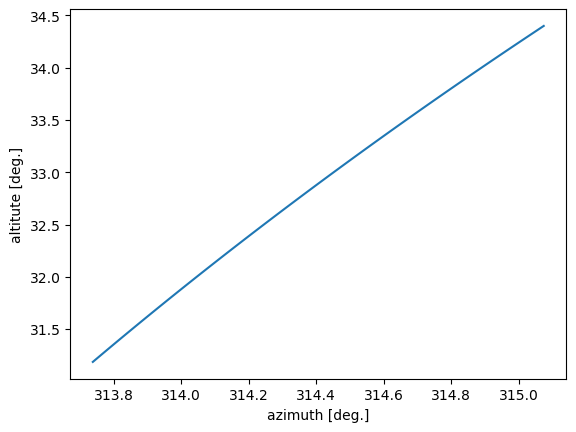

In [332]:
plt.plot(  all_az, all_alt)
plt.xlabel( "azimuth [deg.]")
plt.ylabel( "altitute [deg.]");

## 3. A first look into the events

In [351]:
events_table = Table(events.data)
events_table

EVENT_ID,TIME,RA,DEC,ENERGY
int64,float64,float32,float32,float32
45,333780072.924045,82.171776,22.421804,0.05833082
55,333780072.96587616,83.7298,22.292458,0.050995573
84,333780073.07869804,83.79548,21.145731,0.039031275
120,333780073.1953195,82.03501,21.570885,0.040015426
123,333780073.20475286,83.60063,21.996529,0.13071066
182,333780073.4312252,83.74355,22.04678,0.057374142
232,333780073.5817839,83.505615,22.118025,0.04792382
...,...,...,...,...
7382,333781255.7007259,82.49239,21.967741,0.039261505


In [353]:
energies = events_table['ENERGY']

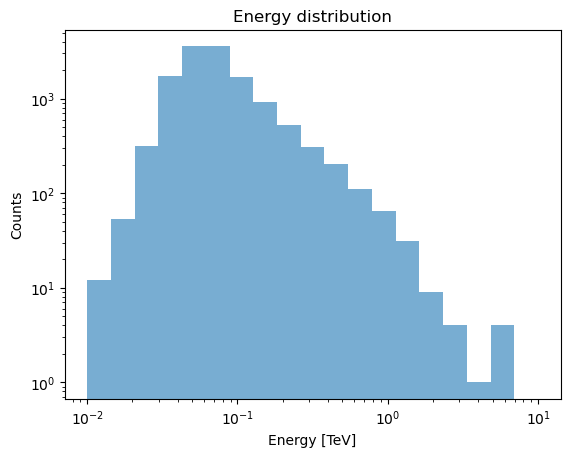

In [354]:
binning = np.logspace(-2,1,20)
plt.hist(energies,bins=binning,alpha=0.6,log=True)
plt.xlabel('Energy [TeV]')
plt.ylabel('Counts')
plt.title('Energy distribution')
plt.xscale('log')

## 4. Source and pointing position

In [355]:
from astropy.visualization.wcsaxes import SphericalCircle
from astropy.wcs import WCS

First we get the pointing postion of the telescope

In [356]:
pointing_pos =  SkyCoord( events.header.get('RA_PNT') *u.deg,   events.header.get('DEC_PNT') *u.deg )
pointing_pos

<SkyCoord (ICRS): (ra, dec) in deg
    (83.27917, 21.78389)>

Then the postion of the source on the sky

In [357]:
source_name = events.header.get('OBJECT')
print(source_name)
source_pos   =  SkyCoord.from_name(events.header.get('OBJECT'))
source_pos

CrabNebula


<SkyCoord (ICRS): (ra, dec) in deg
    (83.633212, 22.01446)>

As you can see the 2 position are not the same (Why?) 

let's compute the offset

In [358]:
offset = source_pos.separation(pointing_pos)
offset.to( u.deg).value

0.40133672039032353

We now compute the angle between the source and the pointing position.

If for instance the two are aligned along a meridian, the angle would be of 0 or 180 degrees, depending on which position one uses as a reference

Let's see it in detail:

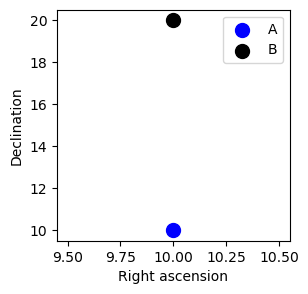

In [359]:
A =  SkyCoord( ra= 10 *u.deg,   dec = 10 *u.deg )
B =  SkyCoord( ra= 10 *u.deg,   dec = 20 *u.deg )

fig, ax =  plt.subplots(figsize=(3,3))

ax = plt.subplot()
ax.scatter(A.ra.value, A.dec.value, marker='o', s=100, c='blue', label ='A'  ) 
ax.scatter(B.ra.value, B.dec.value, marker='o', s=100, c='black', label ='B'  ) 
ax.set_xlabel('Right ascension')
ax.set_ylabel('Declination')
ax.legend();

In [360]:
A.position_angle(B).to(u.degree)

<Angle 0. deg>

The angle between A and B is zero!

In [361]:
B.position_angle(A).to(u.degree)

<Angle 180. deg>

The angle between A and B is instead 180

Excercise:
- Try different position for A and B and get the angle

Let's do this now for the source and pointing position

In [362]:
source_angle = pointing_pos.position_angle(source_pos).to(u.degree)
source_angle

<Angle 54.86912956 deg>

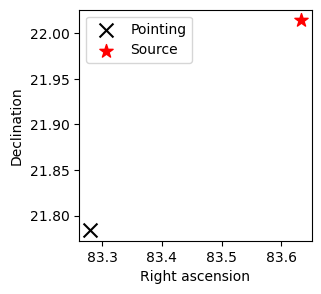

In [363]:
fig, ax =  plt.subplots(figsize=(3,3))

ax = plt.subplot()
ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 
ax.set_xlabel('Right ascension')
ax.set_ylabel('Declination')
ax.legend();

## 5. On and Off regions

Let's now compute the angles for the off positions

In [364]:
off1_angle   = source_angle + 90*u.deg
off2_angle   = off1_angle   + 90*u.deg
off3_angle   = off2_angle   + 90*u.deg

Given the above angles, we now put the off positions on the same offset from the pointing that was used for the source

In [365]:
off1_pos = pointing_pos.directional_offset_by(position_angle=off1_angle, separation=offset)  
off2_pos = pointing_pos.directional_offset_by(position_angle=off2_angle, separation=offset)  
off3_pos = pointing_pos.directional_offset_by(position_angle=off3_angle, separation=offset) 

We can now see the results

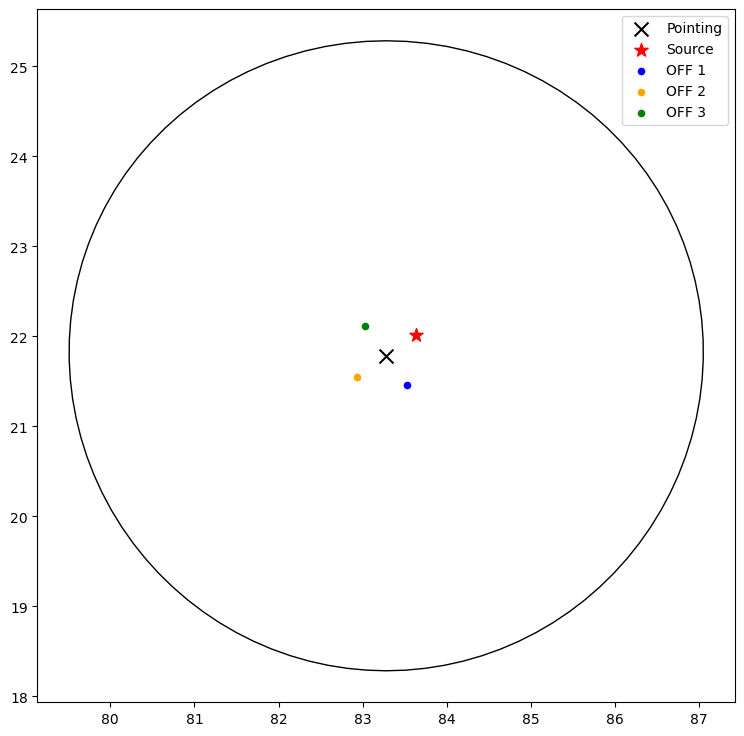

In [366]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = plt.subplot()


field_of_view = SphericalCircle( (pointing_pos.ra, pointing_pos.dec),
                    3.5 * u.deg,   edgecolor='black', facecolor='none')

ax.add_patch(field_of_view)

ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 
ax.scatter(off1_pos.ra.value, off1_pos.dec.value, marker='o', s=20, c='blue', label ='OFF 1'  ) 
ax.scatter(off2_pos.ra.value, off2_pos.dec.value, marker='o', s=20, c='orange', label ='OFF 2'  ) 
ax.scatter(off3_pos.ra.value, off3_pos.dec.value, marker='o', s=20, c='green', label ='OFF 3'  ) 
ax.legend(loc='upper right');

Or even better we can plot the On and Off regions

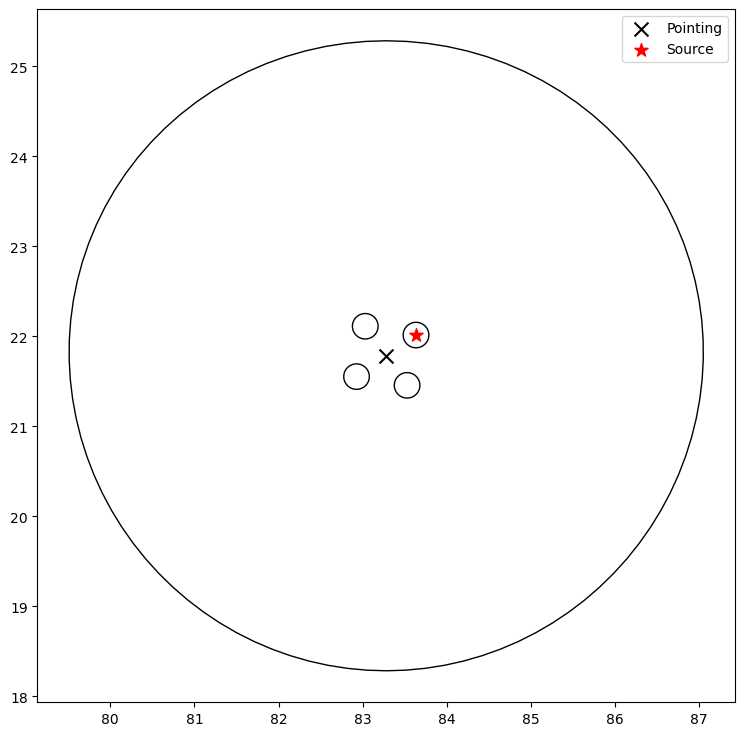

In [367]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = plt.subplot()




field_of_view = SphericalCircle( (pointing_pos.ra, pointing_pos.dec),
                    3.5 * u.deg,   edgecolor='black', facecolor='none')

radius = 0.1414213*u.deg

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

off1 = SphericalCircle( (off1_pos.ra, off1_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off2 = SphericalCircle( (off2_pos.ra, off2_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off3 = SphericalCircle( (off3_pos.ra, off3_pos.dec),
                    radius,   edgecolor='black', facecolor='none')


ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 

ax.add_patch(field_of_view)

ax.add_patch(on)
ax.add_patch(off1)
ax.add_patch(off2)
ax.add_patch(off3)


ax.legend();

## 6. Event selection

We save the evtns as an Astropy Table

We then plot them "on the Sky" using the information on the RA and DEC of each single event

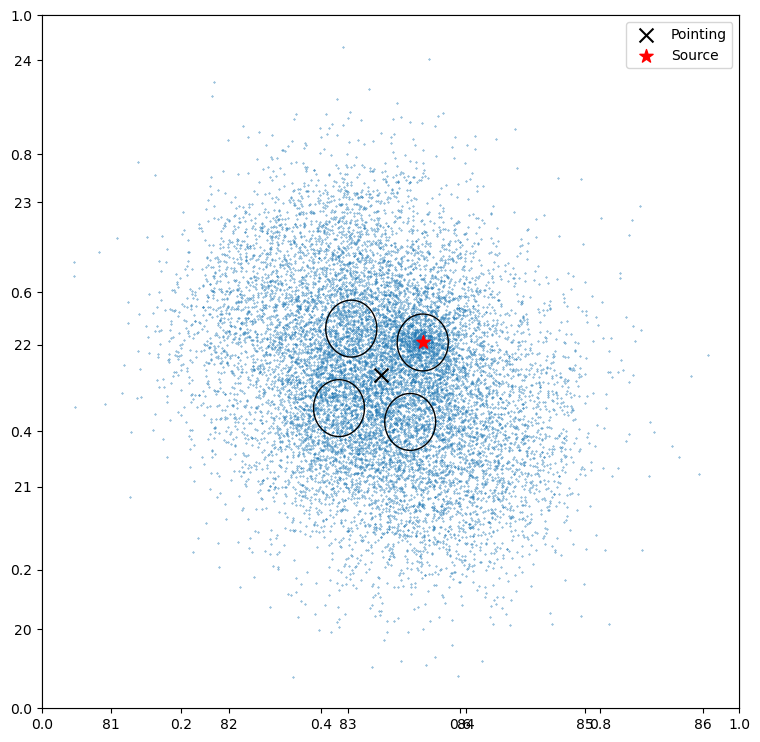

In [371]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = fig.add_subplot()

ra =    events_table['RA'] * u.deg  

dec = events_table['DEC']*u.deg

ax.scatter(ra, dec, s=0.1)


radius = 0.2*u.deg

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

off1 = SphericalCircle( (off1_pos.ra, off1_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off2 = SphericalCircle( (off2_pos.ra, off2_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off3 = SphericalCircle( (off3_pos.ra, off3_pos.dec),
                    radius,   edgecolor='black', facecolor='none')


ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 

ax.add_patch(on)
ax.add_patch(off1)
ax.add_patch(off2)
ax.add_patch(off3)

#ax.set_xlim([47,52])
#ax.set_ylim([40.1,43.7])


ax.legend();

As expected we have more events near the Source!

As one can see from the OFF regions, some of these events are not gamma-rays, but background

Rember that in the Off region we should not expect any gamma-ray

We now select the events in the 4 regions: 1 ON and 3 OFF

In [369]:
ra = events_table['RA'] 
dec = events_table['DEC']

radius = 0.2*u.deg 

cond_on = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_on.append( source_pos.separation(position_event) <= radius )
    
cond_off1 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off1.append( off1_pos.separation(position_event) <= radius )
    
cond_off2 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off2.append( off2_pos.separation(position_event) <= radius )
    

cond_off3 = []
for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    cond_off3.append( off3_pos.separation(position_event) <= radius )
    
    

Let's plot the events we have selected

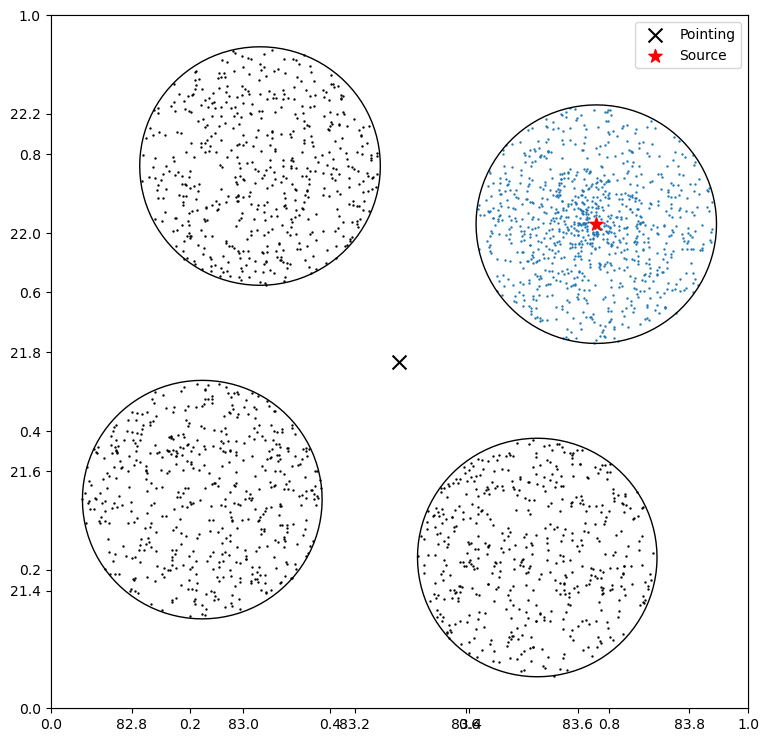

In [372]:
fig, ax =  plt.subplots(figsize=(9,9))

ax = fig.add_subplot()

ra = events_table[cond_on]['RA']
dec = events_table[cond_on]['DEC']
ax.scatter(ra, dec, s=0.5)

ra = events_table[cond_off1]['RA'] 
dec = events_table[cond_off1]['DEC']
ax.scatter(ra, dec, s=0.5, c ='black')

ra = events_table[cond_off2]['RA'] 
dec = events_table[cond_off2]['DEC']
ax.scatter(ra, dec, s=0.5,  c ='black')

ra = events_table[cond_off3]['RA'] 
dec = events_table[cond_off3]['DEC']
ax.scatter(ra, dec, s=0.5,  c ='black')



ax.scatter(pointing_pos.ra.value, pointing_pos.dec.value, marker='x', s=100, c='black', label ='Pointing'  ) 
ax.scatter(source_pos.ra.value, source_pos.dec.value, marker='*', s=100, c='red', label ='Source'  ) 

radius = 0.2*u.deg

on  = SphericalCircle( (source_pos.ra, source_pos.dec),
                    radius,   edgecolor='black', facecolor='none')

off1 = SphericalCircle( (off1_pos.ra, off1_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off2 = SphericalCircle( (off2_pos.ra, off2_pos.dec),
                    radius,   edgecolor='black', facecolor='none')
off3 = SphericalCircle( (off3_pos.ra, off3_pos.dec),
                    radius,   edgecolor='black', facecolor='none')


ax.add_patch(on)
ax.add_patch(off1)
ax.add_patch(off2)
ax.add_patch(off3)



ax.legend();

In [373]:
theta2_on = []

ra = events_table['RA'][cond_on]
dec = events_table['DEC'][cond_on]


for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    theta2_on.append( source_pos.separation(position_event)**2)


theta2_off = []

ra = events_table['RA'][cond_off1]
dec = events_table['DEC'][cond_off1 ]

for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    theta2_off.append( off1_pos.separation(position_event)**2)
    
ra = events_table['RA'][cond_off2]
dec = events_table['DEC'][cond_off2 ]

for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    theta2_off.append( off2_pos.separation(position_event)**2)
    

ra = events_table['RA'][cond_off3]
dec = events_table['DEC'][cond_off3 ]

for i_ra,i_dec in zip(ra,dec):
    position_event = SkyCoord(  i_ra * u.deg, i_dec * u.deg, frame='icrs')

    theta2_off.append( off3_pos.separation(position_event)**2)
    


Text(0.5, 0, '$\\theta^2$')

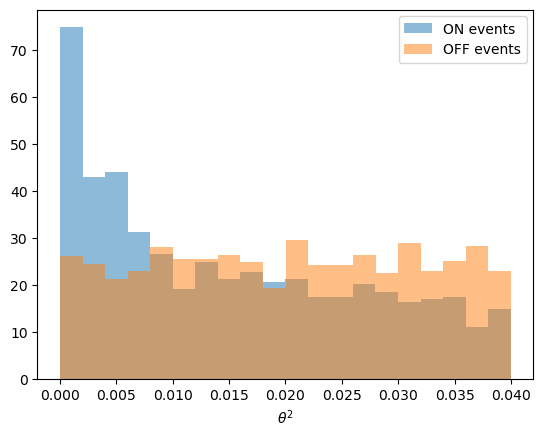

In [374]:
plt.hist(theta2_on,bins=20,density=True,alpha=0.5,label='ON events');
plt.hist(theta2_off,bins=20,density=True,alpha=0.5, label='OFF events');
plt.legend();
plt.xlabel(r'$\theta^2$')

In [375]:
#gammaness_on = events_table['GAMMANESS'][cond_on]

#gammaness_off = events_table['GAMMANESS'][np.array(cond_off1)+np.array(cond_off2)+np.array(cond_off3)]

#plt.hist(gammaness_on,bins=20,density=True,alpha=0.5,label='ON events');
#plt.hist(gammaness_off,bins=20,density=True,alpha=0.5, label='OFF events');
#plt.legend();
#plt.xlabel(r'Gammaness')

## 7. Signal extraction

Total excess

In [377]:
non    = np.sum( cond_on)

noff   = np.sum( cond_off1) +\
         np.sum( cond_off2) +\
         np.sum( cond_off3) 



excess =  non - noff/3 
print(excess)

err_excess =  np.sqrt( non + (1/3)**2*noff) 
print(err_excess)

419.66666666666663
33.42819834278306


We now want the excess in each energy bin

We might define a custom energy binning, but it is better to use the one in the effective area

In [396]:
eff_area = fits_file['EFFECTIVE AREA']
#eff_area = fits_file['AEFF']
eff_area.header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  248 / width of table in bytes                        
NAXIS2  =                    1 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    5 / number of fields in each row                   
TTYPE1  = 'ENERG_LO'           / label for field   1                            
TFORM1  = '20E     '           / data format of field: 4-byte REAL              
TUNIT1  = 'TeV     '           / physical unit of field                         
TTYPE2  = 'ENERG_HI'           / label for field   2                            
TFORM2  = '20E     '        

In [401]:
effective_area = Table( eff_area.data)

theta_low  = np.array( effective_area['THETA_LO'] )[0]
theta_high = np.array( effective_area['THETA_HI'] )[0]

en_low     = np.array( effective_area['ENERG_LO'] )[0]
en_high    = np.array( effective_area['ENERG_HI'] )[0]
en_center = np.sqrt( en_low * en_high )
delta_E  = (en_high - en_low)

eff_area   = np.array( effective_area['EFFAREA'] )[0][0]

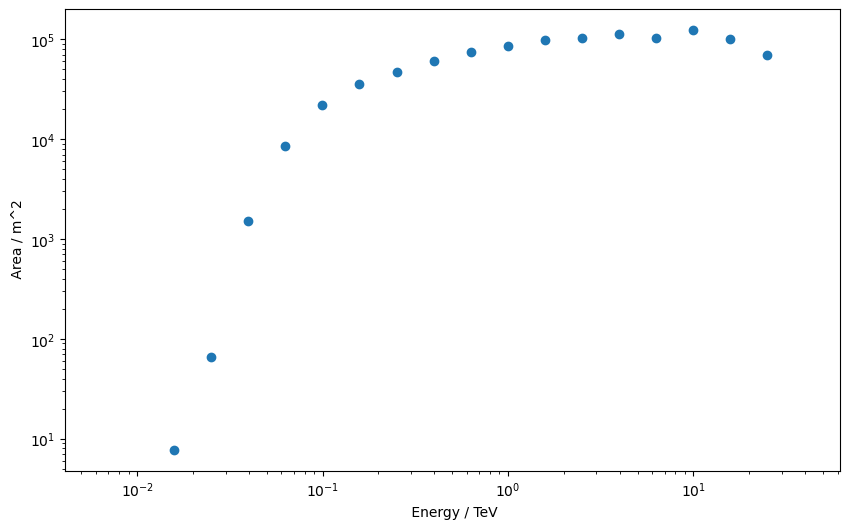

In [402]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)

ax.scatter(en_center,  eff_area)


ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( ' Area / m^2')
ax.set_xscale('log')
ax.set_yscale('log')

Finallt we can compute the excess per energy bin

In [403]:
excess = [] 
err_excess = []

noff_list = []
non_list  = []

for i_en_low, i_en_high in zip( en_low, en_high):
    cond_low  = events_table['ENERGY'] >= i_en_low
    cond_high = events_table['ENERGY']  < i_en_high
    cond_en   = cond_low* cond_high
    
    non    = np.sum( cond_en*cond_on)
    
    noff   = np.sum( cond_en*cond_off1) +\
             np.sum( cond_en*cond_off2) +\
             np.sum( cond_en*cond_off3) 
    
    noff_list.append(noff)
    non_list.append(non)
    
    excess.append( non - noff/3 )
    err_excess.append( np.sqrt( non + (1/3)**2*noff) )
    
excess     = np.array(excess)
err_excess = np.array(err_excess)

non_list   = np.array(non_list)
noff_list   = np.array(noff_list)

Why did I put in the loop `non - noff/3` and not another number like for instance  `non - noff/5` ?

Total Non events in each energy bin

In [404]:
print(non_list)

[  0   0   1  28 142 259 175 114  77  65  32  29  10   5   2   2   1   1
   0   0]


Total Noff events in each energy bin

In [405]:
print(noff_list)

[  1   1   8  74 446 636 243  96  33  19   6   5   2   0   0   0   0   0
   0   0]


Excess in each energy bin

In [406]:
print(excess)

[-0.33333333 -0.33333333 -1.66666667  3.33333333 -6.66666667 47.
 94.         82.         66.         58.66666667 30.         27.33333333
  9.33333333  5.          2.          2.          1.          1.
  0.          0.        ]


Excercise
- Compute the Li&Ma significance for each energy bin using the value of Non and Noff computed (remeber that we are also using $\alpha$ = 1/3)

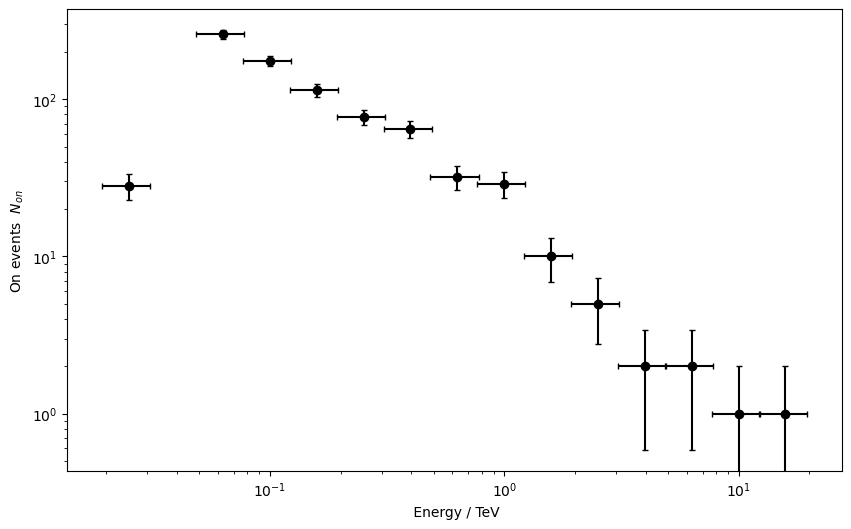

In [416]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=en_center, y=non_list, yerr=np.sqrt(non_list) , xerr = delta_E/2 , c='black', capsize=2, fmt='o')

ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( r'On events  $N_{on}$')
ax.set_xscale('log')
ax.set_yscale('log')

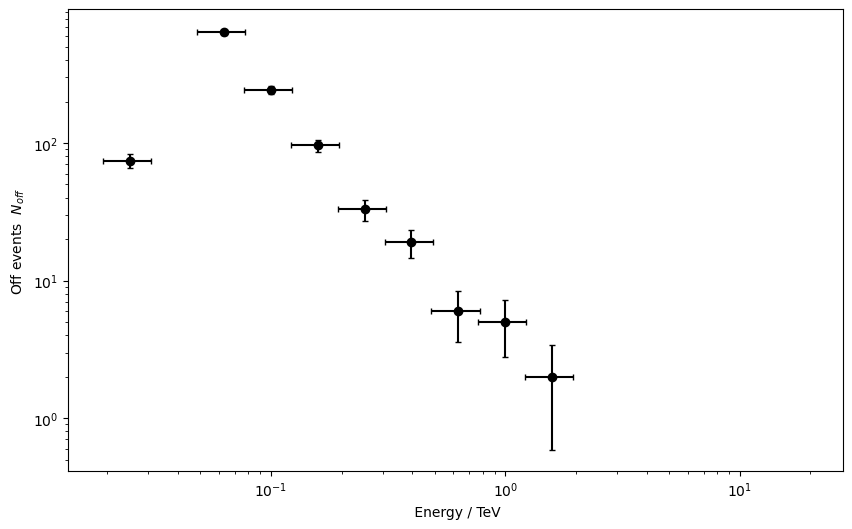

In [417]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=en_center, y=noff_list, yerr=np.sqrt(noff_list) , xerr = delta_E/2 , c='black', capsize=2, fmt='o')

ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( r'Off events  $N_{off}$')
ax.set_xscale('log')
ax.set_yscale('log')

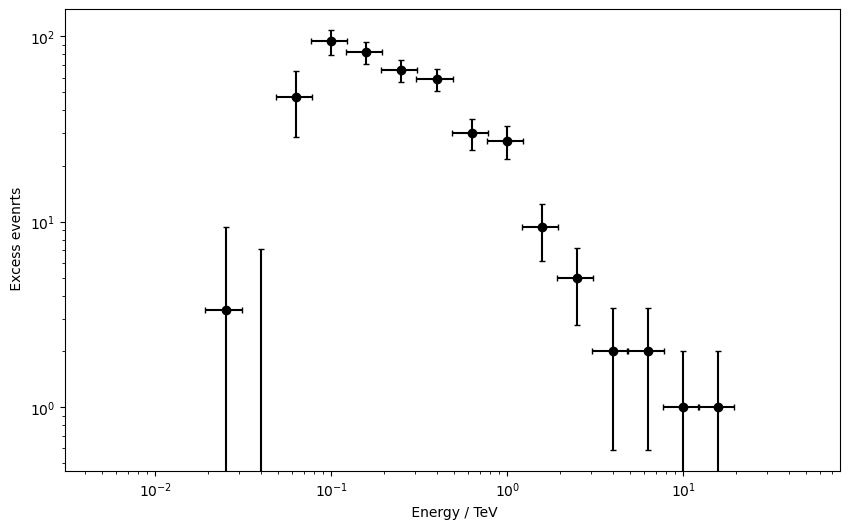

In [407]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=en_center, y=excess, yerr=err_excess , xerr = delta_E/2 , c='black', capsize=2, fmt='o')

ax.set_xlabel( ' Energy / TeV')
ax.set_ylabel( ' Excess evenrts')
ax.set_xscale('log')
ax.set_yscale('log')

## 8. Flux in Energy

In [388]:
exposure_time = events.header.get('LIVETIME') * u.second 
exposure_time.to( u.minute)

<Quantity 19.5809 min>

 WE REMOVE BIN WITH EFF AREA = 0 and EXCESS = 0

In [408]:
cond_aeff  = eff_area >0
cond_exces = excess >0
cond       = cond_aeff*cond_exces


en_center = en_center[cond]
en_low    = en_low[cond]
en_high   = en_high[cond]
delta_E    = delta_E[cond]

eff_area  = eff_area[cond]

excess     = excess[cond]
err_excess = err_excess[cond]

noff_list = noff_list[cond]
non_list  = non_list[cond]

We are now finally ready to compute the flux in each energy bin

In [409]:
flux = excess/( eff_area * u.m**2)/ exposure_time/ ( delta_E *u.TeV)

flux_err = err_excess/( eff_area * u.m**2)/ exposure_time/ ( delta_E *u.TeV)


We can now plot the flux in energy

For reference we will also print the flux we should expect from the Crab Nebula

In [410]:
def log_parababola( e, f0, E0, a, b):
    return f0* (e/E0) **( - a + b* np.log( e/E0))

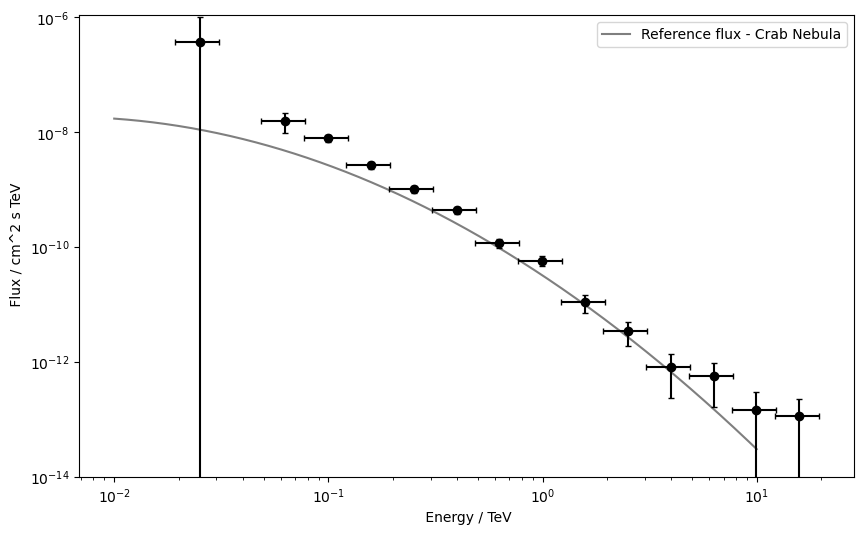

In [411]:
fig, ax = plt.subplots(figsize=(10,6),nrows=1, ncols=1)


ax.errorbar(x=en_center, 
            y=flux.to( 1/(u.TeV * u.cm**2 * u.s) ).value, 
            yerr = flux_err.to( 1/(u.TeV * u.cm**2 * u.s) ).value , 
            xerr = delta_E/2 , c='black', capsize=2, fmt='o')

x = np.logspace(-2,1,1000) * u.TeV
f0 = 3.23e-11 * 1/(u.TeV * u.cm**2 * u.s)
E0 = 1 * u.TeV
a  = 2.47
b  = -0.24
y = log_parababola(x, f0, E0, a, b)

ax.plot(x,y, c='black', alpha=0.5,label='Reference flux - Crab Nebula')

ax.set_ylim([1e-14, None])

ax.set_xlabel( ' Energy / TeV')

ax.set_ylabel( ' Flux / cm^2 s TeV')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend();